In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [5]:
#sample_text = corpus[1]
sample_text = 'вопрос почему например китайский японский UNK'.split(' ')

In [6]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    for token in tokens:
      left_context = []
      right_context = []
      limit = len(tokens) - 1
      token_index = tokens.index(token)
      for n in range(1, window+1):
        if token_index - n >= 0:
          left_context.append(tokens[token_index - n])
        else:
          left_context.append(pad_token)
        if token_index + n <= limit:
          right_context.append(tokens[token_index + n])
        else:
          right_context.append(pad_token)
      splits.append((list(reversed(left_context)), token, right_context))
        
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)

In [9]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [10]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

**Expected:**

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [11]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

**Expected:**

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [12]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

In [13]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for token in tokens:
      limit = len(tokens) - 1
      token_index = tokens.index(token)
      left_context = []
      right_context = []
      for n in range(1, window+1):
        if token_index - n >= 0:
          left_context.append((tokens[token_index - n], token))
        if token_index + n <= limit:
          right_context.append((tokens[token_index + n], token))
      splits.extend(list(reversed(left_context)))
      splits.extend(list(right_context))
    
    return splits

In [14]:
splits = skipgram_split(sample_text, window=2)

In [15]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [16]:
skipgram_split(sample_text, window=2)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

**Expected:**

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [17]:
skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

**Expected:**

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

# SkipGram DataReader

In [4]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for token in tokenized_text:
          limit = len(tokenized_text) - 1
          token_index = tokenized_text.index(token)
          left_context = []
          right_context = []
          for n in range(1, self.window+1):
            if token_index - n >= 0:
              left_context.append((tokenized_text[token_index - n], token))
            if token_index + n <= limit:
              right_context.append((tokenized_text[token_index + n], token))
          splits.extend(list(reversed(left_context)))
          splits.extend(list(right_context))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [7]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 34682.02it/s]


In [8]:
BATCH_SIZE = 512

In [9]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [10]:
for x, y in dataset_loader:
    break

x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

# SkipGram Model


In [11]:
class SkipGram(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [12]:
EMBEDDING_DIM = 20

In [13]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [14]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()

# Training

In [44]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            х = x.view(x.shape[0], -1)

            optimizer.zero_grad()
            
            pred = model(x)
            pred = pred.reshape((pred.shape[0]*pred.shape[1], pred.shape[-1]))

            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()
          
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2986437/2986437 [07:37<00:00, 6532.62it/s, loss=7.18]


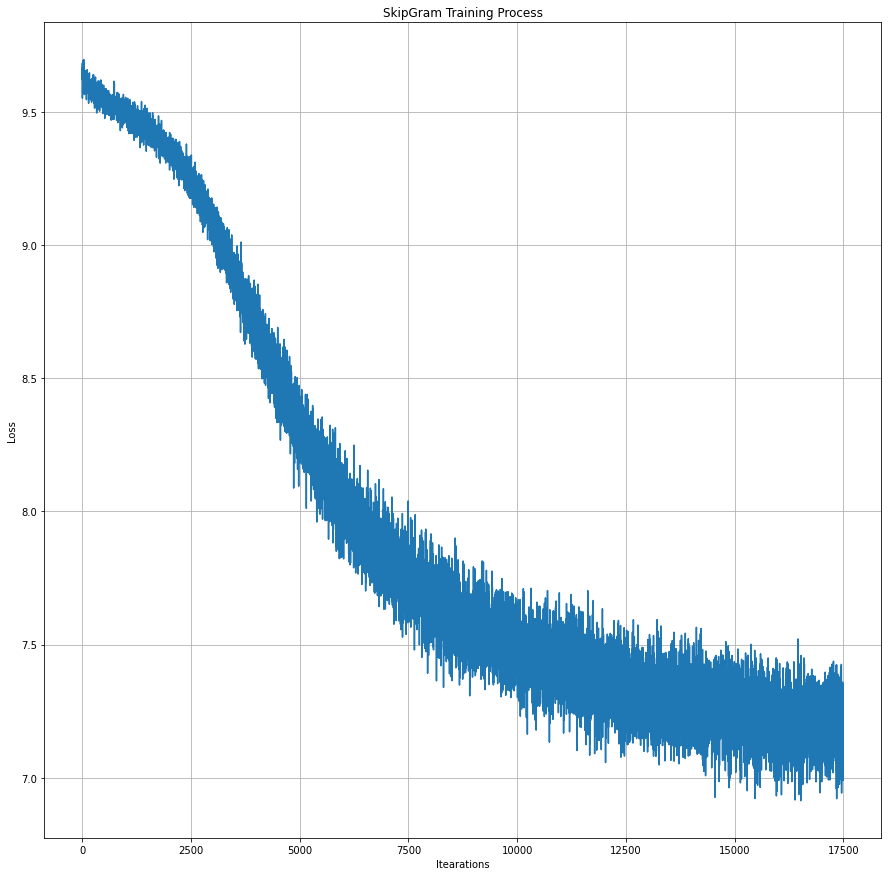

In [45]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [46]:
assert np.mean(losses[-1000:]) < 7.5

# Cosine Similarity

In [47]:
embedding_matrix = model.in_embedding.weight.detach()

In [48]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

In [147]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5734066367149353

In [148]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.31844985485076904

In [149]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.2620704174041748

In [61]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.14069098234176636

In [54]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "разрядиться" равна 0.133'